In [410]:
# подгружаем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import requests
from urllib.parse import urlencode

%matplotlib inline
sns.set()

### Загрузка и первичная обработка данных

Загрузим датасеты, посмотрим на имеющиеся данные, типы данных и пропущенные значения.

In [385]:
# парсим данные
public_key = 'https://disk.yandex.ru/d/4qY27tJ23G_B1g'
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
ab_users_data = pd.read_csv(download_url, sep=',')

public_key = 'https://disk.yandex.ru/d/prdO8FDQx7lzCg'
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
ab_orders = pd.read_csv(download_url, sep=',')

public_key = 'https://disk.yandex.ru/d/atwrlmB_wu-fHA'
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
ab_products = pd.read_csv(download_url, sep=',')

Для начала посмотрим на основной датасет с историей заказов

In [386]:
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


Внешне с данными порядок, нужно только посмотреть размеры выборок для групп, привести даты к дате и присвоить имена группам

In [387]:
# Смотрим размеры выборок
ab_users_data.groupby('group', as_index=False).agg({'user_id': 'nunique'})

,group,user_id
0,0,515
1,1,502


Выборки примерно равны

In [388]:
# Присваиваем имена группам
ab_users_data['group'] = ab_users_data['group'].apply(lambda x: 'control' if x == 0 else 'test')

In [389]:
# применяем тип данных дата к колонкам с датой
ab_users_data.date = pd.to_datetime(ab_users_data.date)
ab_users_data.time = pd.to_datetime(ab_users_data.time)

In [390]:
# Смотрим на типы данных и есть ли пустые значения
ab_users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   4337 non-null   int64         
 1   order_id  4337 non-null   int64         
 2   action    4337 non-null   object        
 3   time      4337 non-null   datetime64[ns]
 4   date      4337 non-null   datetime64[ns]
 5   group     4337 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 203.4+ KB


Пустые значения отсутствуют, типы данных соответствуют, датасет готов к работе.

Посмотрим на датасет с составом заказов.

In [391]:
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


Id товаров лежат в одной ячейке, это помешает мерджить данные с продуктами, поэтому нам нужно их раскидать. И поменяем тип данных у даты.

In [392]:
# Сплитим ячейки и разбиваем на строки, убираем лишние символы
ab_orders['product_ids'] = ab_orders['product_ids'].str.split(',')
ab_orders = ab_orders.explode('product_ids').reset_index(drop=True).rename(columns={'product_ids': 'product_id'})
ab_orders['product_id'] = ab_orders['product_id'].str.replace(r'\D', '', regex=True).astype(int)

In [393]:
# Проверяем
ab_orders.head()

,order_id,creation_time,product_id
0,1255,2022-08-26 00:00:19.000000,75
1,1255,2022-08-26 00:00:19.000000,22
2,1255,2022-08-26 00:00:19.000000,53
3,1255,2022-08-26 00:00:19.000000,84
4,1256,2022-08-26 00:02:21.000000,56


In [394]:
# применяем тип данных дата к колонкам с датой
ab_orders.creation_time = pd.to_datetime(ab_orders.creation_time)

In [395]:
ab_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13826 entries, 0 to 13825
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       13826 non-null  int64         
 1   creation_time  13826 non-null  datetime64[ns]
 2   product_id     13826 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 324.2 KB


Пустые значения отсутствуют, типы данных соответствуют, датасет готов к работе.

Посмотрим на датасет с товарами.

In [396]:
ab_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


Внешне с данными порядок.

In [397]:
ab_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


Пустые значения отсутствуют, типы данных соответствуют, датасет готов к работе.

Думаю, что для удобства нам стоит собрать все данные в один датафрейм и сгруппировать их.

In [398]:
# Мерджим историю заказов, состав заказов и информацию о товарах
delivery_app = pd.merge(ab_users_data, ab_orders, how='left', on='order_id')
delivery_app = pd.merge(delivery_app, ab_products, how='left', on='product_id')

In [399]:
delivery_app.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,2022-08-26 00:00:19,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,2022-08-26 00:00:19,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,2022-08-26 00:00:19,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,test,2022-08-26 00:02:21,56,сосиски,150.0


In [400]:
# Группируем, чтобы убрать повторяющиеся строки
delivery_app = delivery_app.groupby(['user_id', 'order_id', 'action', 'group', 'time', 'date']) \
            .agg({'product_id': 'count', 'price': 'sum'}) \
            .reset_index()

In [401]:
delivery_app.head()

,user_id,order_id,action,group,time,date,product_id,price
0,964,1255,create_order,control,2022-08-26 00:00:19,2022-08-26,4,408.7
1,964,1257,create_order,control,2022-08-26 00:02:27,2022-08-26,4,310.2
2,965,1256,create_order,test,2022-08-26 00:02:21,2022-08-26,3,250.5
3,965,3946,create_order,test,2022-08-27 15:13:59,2022-08-27,4,860.6
4,965,9097,create_order,test,2022-08-29 09:31:42,2022-08-29,6,608.2


У нас дублируются заказы, которые были отменены, из-за чего будет кривая статистика. Например, если мы считаем пользу для бизнеса по срденему чеку, то нам нужно брать средний чек по неотмененным заказам, так как только с них мы получили прибыль. Необходимо убрать у отменненых заказов их дубликат с action = 'create_order'. Отмененные заказы нам будут нужны, когда мы будем смотреть долю отмены.

In [402]:
# Убираем дубликаты отмененных заказов
delivery_app = delivery_app.sort_values(['order_id', 'action']).drop_duplicates(['order_id'], keep='first')

In [403]:
delivery_app

,user_id,order_id,action,group,time,date,product_id,price
0,964,1255,create_order,control,2022-08-26 00:00:19.000000,2022-08-26,4,408.7
2,965,1256,create_order,test,2022-08-26 00:02:21.000000,2022-08-26,3,250.5
1,964,1257,create_order,control,2022-08-26 00:02:27.000000,2022-08-26,4,310.2
11,966,1258,cancel_order,control,2022-08-26 00:08:25.486419,2022-08-26,2,85.0
13,967,1259,create_order,test,2022-08-26 00:03:37.000000,2022-08-26,4,228.0
...,...,...,...,...,...,...,...,...
109,990,59422,create_order,test,2022-09-08 23:13:03.000000,2022-09-08,3,241.2
1984,1418,59439,create_order,test,2022-09-08 23:18:05.000000,2022-09-08,5,518.5
2789,1605,59464,create_order,control,2022-09-08 23:22:27.000000,2022-09-08,3,185.9
2165,1461,59487,create_order,control,2022-09-08 23:29:06.000000,2022-09-08,3,501.9


### Анализ распределения и зависимости числовых переменных

У нас есть ряд явных числовых переменных - цена и кол-во товаров в корзине. Дополнительно мы можем отобразить частоту покупок (заказов).

In [404]:
delivery_app.head()

,user_id,order_id,action,group,time,date,product_id,price
0,964,1255,create_order,control,2022-08-26 00:00:19.000000,2022-08-26,4,408.7
2,965,1256,create_order,test,2022-08-26 00:02:21.000000,2022-08-26,3,250.5
1,964,1257,create_order,control,2022-08-26 00:02:27.000000,2022-08-26,4,310.2
11,966,1258,cancel_order,control,2022-08-26 00:08:25.486419,2022-08-26,2,85.0
13,967,1259,create_order,test,2022-08-26 00:03:37.000000,2022-08-26,4,228.0


Уберем отмененные заказы, они нам сейчас не нужны.

In [415]:
delivery_less_canceled = delivery_app.query("action != 'cancel_order'")

Посмотрим на общую картину распределения и корелляции в разрезе двух групп с помощью паирплота

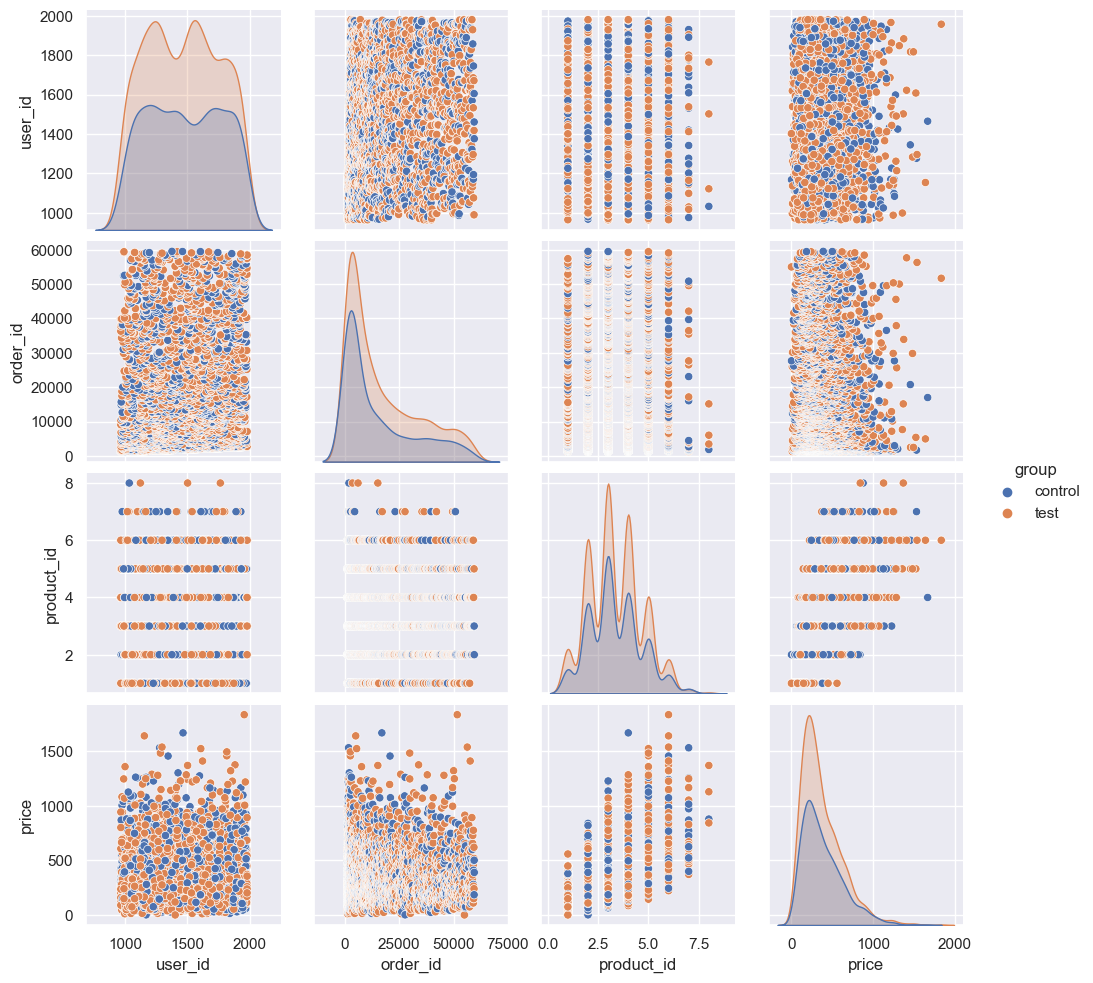

In [417]:
# Строим паирплот
sns.pairplot(delivery_less_canceled, hue='group')

О нормальности распределений говорить тяжело, она нас особо и не интересует, если мы будем использовать т-тест. Самое главное, что на графиках видно, что у нас есть изменения в числовых переменных в зависимости от группы. Тестовая группа показывает более высокие показатели по цене и кол-ву товаров в заказе. Есть определенный смысл провести тестирование гипотез по данным метрикам.

Давайте взглянем на частоту покупок пользователей. Покупкой будем считать заказы, которые не отменены.

In [461]:
purchases = delivery_app.query("action != 'cancel_order'") \
            .groupby(['user_id', 'group']) \
            .agg({'order_id': 'nunique'}) \
            .rename(columns={'order_id': 'purchase_frequency'}) \
            .reset_index()

In [446]:
purchases

,user_id,group,count_purchase
0,964,control,2
1,965,test,9
2,967,test,5
3,968,control,3
4,969,control,2
...,...,...,...
1008,1976,test,5
1009,1977,test,4
1010,1978,test,6
1011,1979,test,5


<Axes: xlabel='purchase_frequency', ylabel='Count'>

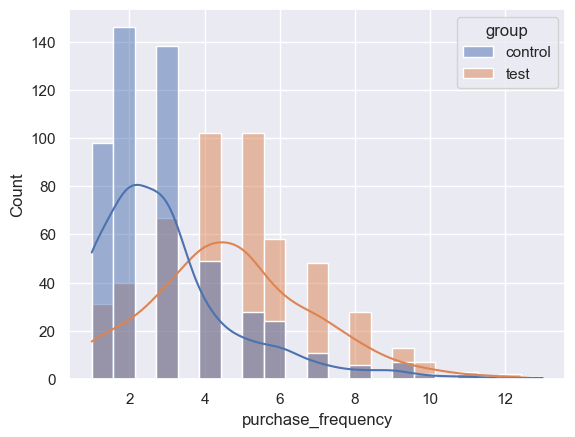

In [462]:
sns.histplot(purchases, x='purchase_frequency',hue='group', kde=True)

### Анализ категориальных переменных

У нас есть две явных категориальных переменных - это группа и состояние заказа (отменен или создан). Посмотрим на их количественные показатели и взаимосвязи.

Через гистрограмму посмотрим, как группа повлияла на созданные и отмененные заказы.

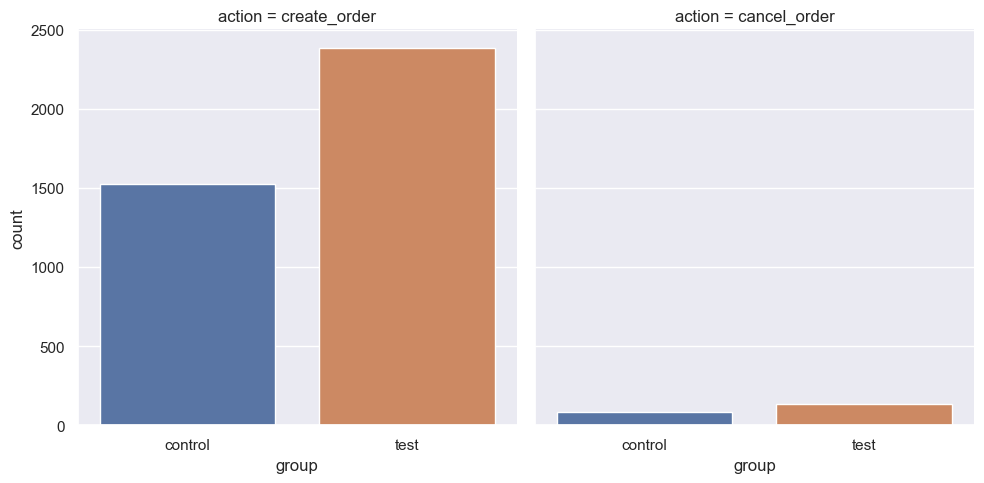

In [418]:
# строим график влияния группы на мэтчи
sns.catplot(
    delivery_app, kind="count",
    x="group", col="action"
)

Изменения видно сходу - заказывать стали больше, отмены тоже выросли. Посмотрим на процентное соотношение.

In [419]:
# Создаем датафрейм с процентным соотношением статусов в группах
status_group_perc = (delivery_app.groupby('group')['action']
        .value_counts(normalize = True).round(2)
        .to_frame('perc').reset_index()
          )

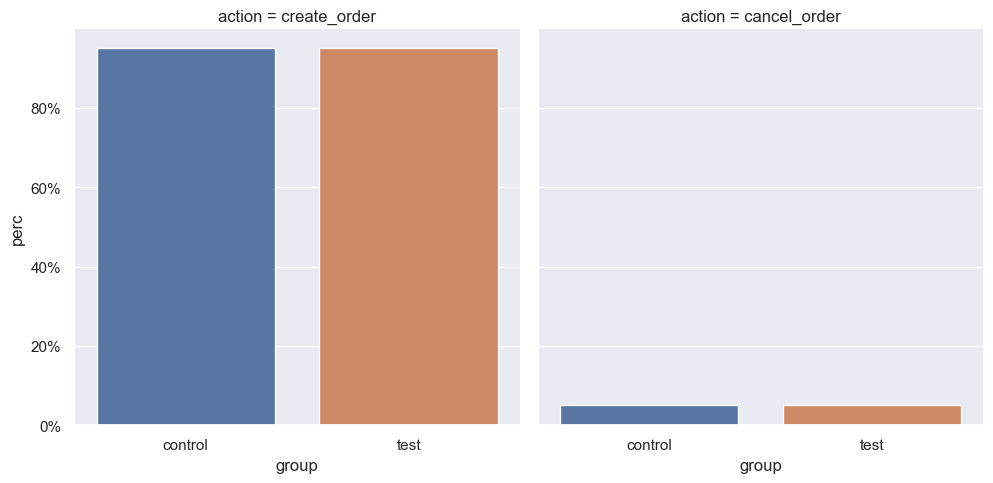

In [420]:
# Рисуем гистограмму
from matplotlib.ticker import PercentFormatter
p = sns.catplot(status_group_perc, x='group', y='perc', col='action', kind='bar')
for ax in p.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))

Так интереснее - в процентном соотношении показатели не изменились, отмен не стало меньше, но и больше не стало.

### Выявление выбросов и аномалий

Выбросы и аномалии посмотрим в цене и кол-ве товаров в заказе. Для этого будем использовать боксплот.

In [470]:
# Делаем отдельную переменную для контрольной группы
control = delivery_less_canceled.query("group == 'control'")

In [475]:
# Делаем отдельную переменную для тестовой группы
test = delivery_less_canceled.query("group == 'test'")

<Axes: >

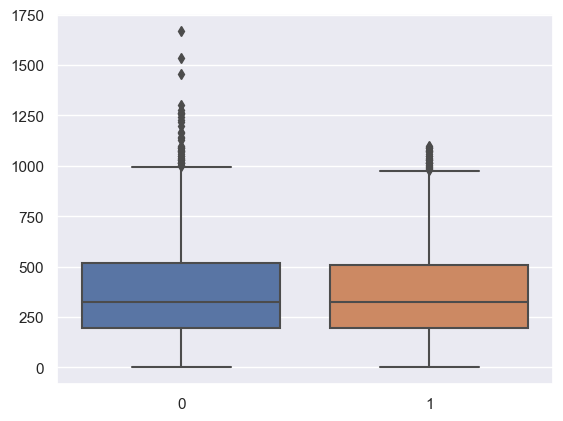

In [468]:
# Строим барплот для цены
sns.boxplot([control.price, test.price])

Много выбросов в обоих группах, пока что убирать не будем, решим на этапе тестирования. Визуально кажется, что новая версия не повлияла на цену.

<Axes: >

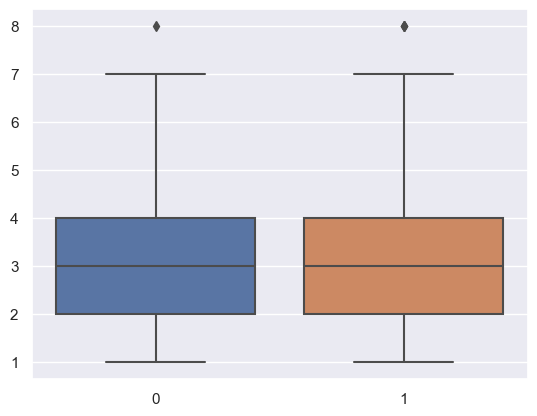

In [474]:
# Строим барплот для товаров в заказе
sns.boxplot([control.product_id, test.product_id])

По боксплоту количества товаров в заказе складывается ощущение, что новый алгоритм рекомендаций не смог повлиять на кол-во заказываемых товаров. Выбросы единичны. Возможно, даже не буду рассматривать, если в других метриках нет ста значимых различий.

In [477]:
purchases_control = purchases.query("group == 'control'")
purchases_test = purchases.query("group == 'test'")

<Axes: >

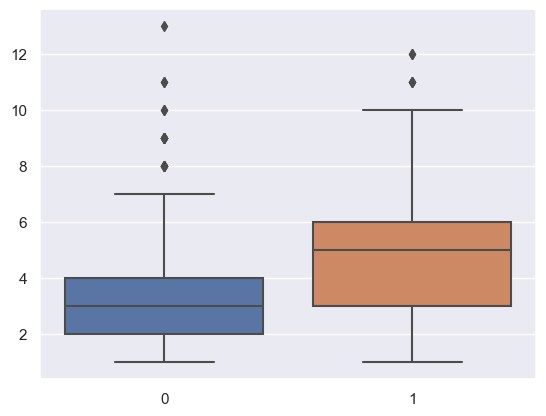

In [478]:
# Строим барплот для частоты покупок
sns.boxplot([purchases_control.purchase_frequency, purchases_test.purchase_frequency])

По боксплоту количества покупок видим изменения в пользу новой версии, также есть незначительные выбросы.

### Выбор метрик

Считаю, что оценить пользу новой версии приложения для бизнеса и пользователей, нам помогут следующие метрики:
    
- Средний чек (изменение денежного показателя явно покажет пользу бизнесу)
- Доля отмены (если отмененных заказов стало меньше, то это указывает на повышение качества сервиса)
- Частота покупок (если частота покупок увеличилась, что это указывает на лояльность клиентов и одобрение сервиса с их стороны)

Дополнительно (хотел, но не успел):
- Среднее кол-во товаров в корзине (алгоритм рекомендаций должен теоретически повысить этот показатель).
- Ретеншен (возвращаемость пользователей) - у нас есть заказы и дата заказов, мы можем проверить улучшился ли RR.
    

### Проверяем гипотезу разницы среднего чека

Используем t-test стьюдента

**Наши гипотезы**

- Н0 средний чек до и после введения нового алгоритма равны
- Н1 средний чек до и после введения нового алгоритма не равны

Для проведения т-теста, нам необходимо, чтобы дисперсии двух групп были гомогенны. Проверить это с помощью теста Бартлетта.

In [434]:
delivery_less_canceled.head()

,user_id,order_id,action,group,time,date,product_id,price
0,964,1255,create_order,control,2022-08-26 00:00:19,2022-08-26,4,408.7
2,965,1256,create_order,test,2022-08-26 00:02:21,2022-08-26,3,250.5
1,964,1257,create_order,control,2022-08-26 00:02:27,2022-08-26,4,310.2
13,967,1259,create_order,test,2022-08-26 00:03:37,2022-08-26,4,228.0
18,968,1261,create_order,control,2022-08-26 00:05:35,2022-08-26,4,430.7


In [479]:
# проводим тест бартлетта
st.bartlett(control.price, test.price)

BartlettResult(statistic=0.06797194273554505, pvalue=0.7943128427034115)

p.value > 0.05, поэтому мы не можем отвергнуть нулевую гипотезу, у нас нет достаточных доказательств того, что наши группы имеют разные дисперсии.

In [480]:
# Проводим т-тест
ttest_ind(control.price, test.price)

Ttest_indResult(statistic=1.6334875192269402, pvalue=0.10244707728234667)

p.value > 0.05, поэтому мы не можем отвергнуть нулевую гипотезу, у нас нет достаточных доказательств того, что средний чек статическо значимо изменился с использованием новой версии приложения.

In [481]:
# проводим тест манна-уитти
st.mannwhitneyu (control.price, test.price)

MannwhitneyuResult(statistic=1879871.0, pvalue=0.07538521320232093)

Тест манна-уитти также показал, что статически значимые изменения отсутсвуют.

### Проверяем гипотезу изменения доли отмененных заказов

Используем Хи-квадрат тест независимости

**Наши гипотезы**

- Н0 статусы заказа и алгоритм независимы
- Н1 статусы заказов и алгоритм зависимы

In [431]:
crosstab_delivery_app

action,cancel_order,create_order
group,,
control,82,1527
test,132,2382


In [427]:
# Создаем сводную таблицу
crosstab_delivery_app = pd.crosstab(delivery_app.group, delivery_app.action)

In [428]:
stat, p, dof, expected = st.chi2_contingency(crosstab_delivery_app)

In [429]:
stat, p

(0.021274207290295184, 0.8840344321879333)

In [430]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем нулевую гипотезу')
else:
    print('НЕ отклоняем нулевую гипотезу')

НЕ отклоняем нулевую гипотезу


Поскольку p-значение нашего теста выше, чем альфа = 0,05, мы не можем отвергнуть нулевую гипотезу. У нас не достаточно данных, чтобы сказать, что статически значимо зависемы. То есть с большей вероятностью новая версия не повлияла на отмененные заказы.

### Проверяем гипотезу разницы среднего количества покупок

Используем t-test стьюдента

**Наши гипотезы**

- Н0 среднюю частоту покупок до и после введения нового алгоритма равны
- Н1 среднюю частоту покупок до и после введения нового алгоритма не равны

Для проведения т-теста, нам необходимо, чтобы дисперсии двух групп были гомогенны. Проверить это с помощью теста Бартлетта.

In [482]:
purchases.head()

,user_id,group,purchase_frequency
0,964,control,2
1,965,test,9
2,967,test,5
3,968,control,3
4,969,control,2


In [483]:
# проводим тест бартлетта
st.bartlett (purchases_control.purchase_frequency, purchases_test.purchase_frequency)

BartlettResult(statistic=7.921440725807878, pvalue=0.004885235475578573)

p.value < 0.05, поэтому мы можем отвергнуть нулевую гипотезу, у нас есть достаточных доказательств того, что наши группы имеют разные дисперсии. Мы не можем использоват т-тест Стьюдента, поэтому будем использовать Манна-Уитни.

In [484]:
# проводим тест манна-уитти
st.mannwhitneyu (purchases_control.purchase_frequency, purchases_test.purchase_frequency)

MannwhitneyuResult(statistic=62993.5, pvalue=1.2199751971495041e-45)

p.value < 0.05, поэтому мы можем отвергнуть нулевую гипотезу, у нас есть достаточно доказательств того, что средняя частота покупок статическо значимо изменилось с использованием новой версии приложения.

In [486]:
# смотрим на сколько изменилось кол-во покупок в среднем
purchases.groupby('group').agg({'purchase_frequency': 'mean'}).round(2)

,purchase_frequency
group,
control,2.98
test,4.75


In [487]:
4.75/2.98

1.5939597315436242

в серднем в 1.5 раза увеличилась частота покупок

# Вывод

На основе полученных данных и проведенных тестов трудно сделать вывод, что новая версия приложения принесла пользу бизнесу - она не смогла повлиять на средний чек и уменьшить долю отмененных заказов. Однако она увеличила частоту покупок в 1.5 раза. Количество товаров в заказе я решил не рассматривать на фоне других тестов, думаю там также нет ста значимых различий, так как на боксплоте группы вообще не различались. Мы можем сказать, что новая версия приложения повысила лояльность клиентов и если это наша ключевая цель, то мы можем выкатывать новую версию. Однако если главная цель увеличение прибыли, то не стоит торопиться с обновлением.